# Import packages and load data

This code shows how you can transform your aspect text and sentence information to iob-labels to evaluate the output.

It expects a Pandas DataFrame with:


1.   The text of the sentence.
2.   The entity text.
3.   The entity category.

The Notebook shows you how to, using this information, add a new column to your dataframe with **IOB-labels** as shown below.

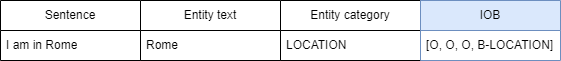



---

❗🧠 If you're unsure what IOB-labels are and why we use them, look up more information about **span evaluation** and **evaluation metrics**, such as F1, accuracy, recall and precision. The package we'll use to evaluate our spans is [Nervaluate](https://pypi.org/project/nervaluate/).




In [ ]:
import pandas as pd
import string
import re
import ast

In [ ]:
!git clone https://github.com/TessDejaeghere/example_data_CLS.git

Cloning into 'example_data_CLS'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 52 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 7.42 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
path = "/content/example_data_CLS/"
training_df = pd.read_csv("example_data_CLS/EN_fauna_flora_df.csv")

## Load example corpus

Let's load an example corpus which we created to annotate travelogues with **Fauna** and **Flora** aspects. 🌺🐱

In [ ]:
training_df.head()

,Unnamed: 0,sentence,text,_sentence_text,aspect_cat
0,0,GB-117_sample_English_18.txt_4026-4114,Tropic Bird,"In the A.M. saw a Tropic Bird , which , I beli...",FAUNA
1,1,GB-117_sample_English_18.txt_7251-7283,flying fish,Some flying fish seen this day .,FAUNA
2,2,GB-117_sample_English_18.txt_7364-7486,Egg Bird,"In the P.M. saw an Egg Bird , and yesterday a ...",FAUNA
3,3,GB-117_sample_English_18.txt_7364-7486,Gannet,"In the P.M. saw an Egg Bird , and yesterday a ...",FAUNA
4,4,GB-117_sample_English_18.txt_7364-7486,Birds,"In the P.M. saw an Egg Bird , and yesterday a ...",FAUNA


In [ ]:
#dataframe is given per sentence id
#the output of the LLM is also parsed as a list of entities and then transformed to IOB-format.
#We do the same here for the gold entities.
training_df = training_df.groupby(["sentence"]).agg(list)

In [ ]:
training_df["_sentence_text"] = training_df["_sentence_text"].apply(lambda x: x[0])

In [ ]:
training_df.sample(10)

,Unnamed: 0,text,_sentence_text,aspect_cat
sentence,,,,
GB-108_sample_English_20.txt_20983-21088,[765],[mules],"The mules suffered severely , and drops of blo...",[FAUNA]
GB-108_sample_English_20.txt_6864-7281,"[660, 661]","[mules, mules]","Though there were a hundred mules , this did n...","[FAUNA, FAUNA]"
GB-138_sample_English_20.txt_15939-16168,[74],[animal life],"In doing this , there came to me slowly the so...",[FAUNA]
GB-29_sample_English_19.txt_22313-22433,[637],[elk],"Large herds of elk were frequently started , a...",[FAUNA]
GB-111_sample_English_20.txt_894-989,[521],[turkeys],"No wild turkeys are found in the park now , al...",[FAUNA]
GB-29_sample_English_19.txt_20228-20424,[631],[horses],By pressing our horses hard we succeeded in cr...,[FAUNA]
GB-70_sample_English_19.txt_4730-4893,[151],[mare],"That night , after a tiring day , I was sleepi...",[FAUNA]
GB-29_sample_English_19.txt_37-126,[616],[horses],Tyrwhitt Brooks\nLanguage: English\nOur person...,[FAUNA]
GB-91_sample_English_20.txt_22743-23023,"[58, 59, 60, 61, 62]","[vertebrate animal, mammoth penguins, leaves, ...",Other shorter trips taken over the islands in ...,"[FAUNA, FAUNA, FLORA, FLORA, FLORA]"


# Annotations to IOB

This Notebook takes a dataframe of annotations, and outputs a dataframe with IOB-style annotations based on:
1. The sentence.
2. The entity text.
3. The entity category.

**Input**

text_name | entity_text | sentence_text
-------------|------------|------------
file.txt      |Rome| All roads lead to Rome.


**Output**


Sentence_id | Entity_text | Entity_sentence | Bio-labels
-------------|------------|------------|------------
01      |Rome| All roads lead to Rome. | [0,0,0,0,B-LOC,0]



---


❗ The method splits the tokens based on a space. It should be language-agnostic! Adapt the methodology according to your own definition of a **token**.

In [ ]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))

    return results

In [ ]:
def to_IOB(sentence, entity_list, category_list):

  sentence = str(sentence)
  entity_list = ast.literal_eval(entity_list)
  category_list = ast.literal_eval(category_list)


  #remove newline character from entities in entity_list
  entity_list = [entity.replace("\n", " ") for entity in entity_list]

  #remove line breaks from string
  sentence = sentence.replace('\n', ' ')

  sentence = re.findall(r"[\w']+|[.,!?;]", sentence)

  #split sentence and make into list with O's
  sentence_O = [["O"] * len(sentence)][0]

  if len(entity_list) != 0:
      for ent_index, ent in enumerate(entity_list):

        ent = re.findall(r"[\w']+|[.,!?;]", ent)

        #find indices of sublist entity in list sentence
        ind = find_sub_list(ent, sentence)
        label = category_list[ent_index]


        #insert IOB-aspect pattern into sentence with O's

        for result in ind:
          #make list of numbers out of index information [(51,53)] = [51,52,53]
          all_indices = list(range(result[0], result[-1]+1))

      #index of start aspect = B-aspect
          start_index = all_indices[0]
          sentence_O[start_index] = "B-" + label

      #index of other parts of the aspect = I-aspect
          other_indices = all_indices[1:]
          for other_ind in other_indices:
              sentence_O[other_ind] = "I-" + label

  return sentence, sentence_O

In [ ]:
to_IOB("I am going to Roma\nRoma to see the deer, the Roma\nRoma are beautiful! I saw a C. Concla.", ["Roma\nRoma", "deer", "Roma\Roma", "C. Concla"], ["LOC", "FAUNA", "LOC", "FAUNA"])

([['I',
   'am',
   'going',
   'to',
   'Roma',
   'Roma',
   'to',
   'see',
   'the',
   'deer',
   ',',
   'the',
   'Roma',
   'Roma',
   'are',
   'beautiful',
   '!',
   'I',
   'saw',
   'a',
   'C',
   '.',
   'Concla',
   '.']],
 [['O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'O',
   'B-FAUNA',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-FAUNA',
   'I-FAUNA',
   'I-FAUNA',
   'O']])

In [ ]:
#results to IOB-format for span evaluation
training_df['results'] = training_df.apply(lambda x: to_IOB(x._sentence_text, x.text, x.aspect_cat), axis= 1)

In [ ]:
training_df['sentence_split'], training_df['iob'] = zip(*training_df.results)

In [ ]:
training_df.head(10)

,Unnamed: 0,text,_sentence_text,aspect_cat,sentence_split,iob,results
sentence,,,,,,,
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],"[It, is, very, closely, allied, to, B, ., aren...","[O, O, O, O, O, O, B-FAUNA, I-FAUNA, I-FAUNA, ...","([It, is, very, closely, allied, to, B, ., are..."
BHL_118_sample_English_20.0.txt_10264-10274,[106],[Plankton],Plankton .,[FAUNA],"[Plankton, .]","[B-FAUNA, O]","([Plankton, .], [B-FAUNA, O])"
BHL_118_sample_English_20.0.txt_10303-10313,[107],[Plankton],Plankton .,[FAUNA],"[Plankton, .]","[B-FAUNA, O]","([Plankton, .], [B-FAUNA, O])"
BHL_118_sample_English_20.0.txt_10329-10343,[108],[Cyclaspoides],Cyclaspoides .,[FAUNA],"[Cyclaspoides, .]","[B-FAUNA, O]","([Cyclaspoides, .], [B-FAUNA, O])"
BHL_118_sample_English_20.0.txt_10347-10364,[109],[Cyclaspoides],Cyclaspoides sp .,[FAUNA],"[Cyclaspoides, sp, .]","[B-FAUNA, O, O]","([Cyclaspoides, sp, .], [B-FAUNA, O, O])"
BHL_118_sample_English_20.0.txt_10442-10528,[110],[Tunicate],Sluiter in the atrial cavity of a species of T...,[FAUNA],"[Sluiter, in, the, atrial, cavity, of, a, spec...","[O, O, O, O, O, O, O, O, O, B-FAUNA, O, O, O, ...","([Sluiter, in, the, atrial, cavity, of, a, spe..."
BHL_118_sample_English_20.0.txt_1101-1286,[88],[C. exsculpta Sars],"Resembling C. exsculpta Sars , in the general ...",[FAUNA],"[Resembling, C, ., exsculpta, Sars, ,, in, the...","[O, B-FAUNA, I-FAUNA, I-FAUNA, I-FAUNA, O, O, ...","([Resembling, C, ., exsculpta, Sars, ,, in, th..."
BHL_118_sample_English_20.0.txt_11082-11174,[111],[Tunicate],The occurrence of the specimen in the atrial c...,[FAUNA],"[The, occurrence, of, the, specimen, in, the, ...","[O, O, O, O, O, O, O, O, O, O, O, B-FAUNA, O, ...","([The, occurrence, of, the, specimen, in, the,..."
BHL_118_sample_English_20.0.txt_11338-11370,[112],[HcteroatDia { t ) Weberi],HcteroatDia { t ) Weberi n. sp .,[FAUNA],"[HcteroatDia, t, Weberi, n, ., sp, .]","[B-FAUNA, I-FAUNA, I-FAUNA, O, O, O, O]","([HcteroatDia, t, Weberi, n, ., sp, .], [B-FAU..."


In [ ]:
training_df.drop(["results"], inplace = True, axis = 1)

In [ ]:
training_df = training_df.explode(["sentence_split", "iob"])

In [ ]:
training_df.head()

,Unnamed: 0,text,_sentence_text,aspect_cat,sentence_split,iob
sentence,,,,,,
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],It,O
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],is,O
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],very,O
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],closely,O
BHL_118_sample_English_20.0.txt_10188-10237,[105],[B. arenosa Goodsir],It is very closely allied to B. arenosa Goodsir .,[FAUNA],allied,O


# IOB-results to space-separated .txt-file

To train Flair's SequenceTagger, you need the IOB-labelled data in a **tab-separated .txt-file** with token + (tab) + label.

Like so:

I O

am O

travelling O

to O

Rome B-LOC

. O

\n

I O

saw O

deer B-FAUNA

and O

banana B-FLORA

trees I-FLORA

. O

The SequenceTagger expects every sentence to be separated by a newline.
You can reuse the code below to help you put the data in the correct format!

In [ ]:
def to_file(train_df):
  filename =

    with open(f"/content/{filename}.txt", "w") as f:
        for el in sents_df: #for every sentence
            for text, label in zip(el[1]["text"], el[1]["bio"]):
                print("{}\t{}".format(text, label), file=f)
            print("\n", file = f)

In [ ]:
with open(f"/content/train.txt", "w") as f:
  for ind in training_df.index: #for each sentence
    words = training_df['sentence_split'][ind]
    iob = training_df['iob'][ind]
    for word, iob_label in zip(words, iob):
      print("{}\t{}".format(word, iob_label), file=f)
    print("\n", file = f)



# Example: load test set and transform to IOB-labels

This shows you how to use a lambda function to apply our IOB-labeller to a dataset for both the gold standard data and the data generated by our model.

❗🧠 It is very important that we use the same tokenization technique to generate IOB-labels for both the gold standard entities and the generated entities! If these are not correctly aligned, the results will be skewed.

In [ ]:
test_set = pd.read_csv("test_set_llm.csv")

In [ ]:
test_set["output_gs"] = test_set.apply(lambda x: to_IOB(x._sentence_text, x.text, x.aspect_cat), axis= 1)

In [ ]:
test_set["output_llm"] = test_set.apply(lambda x: to_IOB(x._sentence_text, x.text_llm, x.aspect_cat_llm), axis= 1)

In [ ]:
test_set["sentence_split"], test_set["iob_gs"] = zip(*test_set.output_gs)

In [ ]:
test_set["sentence_split"], test_set["iob_llm"] = zip(*test_set.output_llm)

In [ ]:
test_set

,text,_sentence_text,aspect_cat,NER_results,text_llm,aspect_cat_llm,output_gs,output_llm,sentence_split,iob_gs,iob_llm
0,['bloesems'],In de eerste plaats noem ik de bloesems .,['FLORA'],"(['bloesems'], ['FLORA'])",['bloesems'],['FLORA'],"([In, de, eerste, plaats, noem, ik, de, bloese...","([In, de, eerste, plaats, noem, ik, de, bloese...","[In, de, eerste, plaats, noem, ik, de, bloesem...","[O, O, O, O, O, O, O, B-FLORA, O]","[O, O, O, O, O, O, O, B-FLORA, O]"
1,"['Centroplites', 'Padden', 'Schildpadden']",Centroplites . y Kik- ( 177 ) Kikvorscheiij Pa...,"['FAUNA', 'FAUNA', 'FAUNA']","(['Centroplites', 'Kikvorscheiij Padden', 'Sch...","['Centroplites', 'Kikvorscheiij Padden', 'Schi...","['FAUNA', 'FAUNA', 'FAUNA']","([Centroplites, ., y, Kik, 177, Kikvorscheiij,...","([Centroplites, ., y, Kik, 177, Kikvorscheiij,...","[Centroplites, ., y, Kik, 177, Kikvorscheiij, ...","[B-FAUNA, O, O, O, O, O, B-FAUNA, O, B-FAUNA, O]","[B-FAUNA, O, O, O, O, B-FAUNA, I-FAUNA, O, B-F..."
2,"['tuin', 'veldvrugten']","Het antwoord was , dat zy die ver naar 't Noor...","['FLORA', 'FLORA']","([], [])",[],[],"([Het, antwoord, was, ,, dat, zy, die, ver, na...","([Het, antwoord, was, ,, dat, zy, die, ver, na...","[Het, antwoord, was, ,, dat, zy, die, ver, naa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,['M. communis'],"Suppl . ) , en volgende schrijvers , geven een...",['FLORA'],"(['M. communis'], ['FLORA'])",['M. communis'],['FLORA'],"([Suppl, ., ,, en, volgende, schrijvers, ,, ge...","([Suppl, ., ,, en, volgende, schrijvers, ,, ge...","[Suppl, ., ,, en, volgende, schrijvers, ,, gev...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-FLOR...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-FLOR..."
4,"['Cereus', 'Melocactus']","Eene bizonderheid , die ook op dat eiland bij ...","['FLORA', 'FLORA']","([], [])",[],[],"([Eene, bizonderheid, ,, die, ook, op, dat, ei...","([Eene, bizonderheid, ,, die, ook, op, dat, ei...","[Eene, bizonderheid, ,, die, ook, op, dat, eil...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5,"['Beukenbomen', 'zaden']","In de boflchen vindt men veel Beukenbomen , we...","['FLORA', 'FLORA']","(['Beukenbomen'], ['FLORA'])",['Beukenbomen'],['FLORA'],"([In, de, boflchen, vindt, men, veel, Beukenbo...","([In, de, boflchen, vindt, men, veel, Beukenbo...","[In, de, boflchen, vindt, men, veel, Beukenbom...","[O, O, O, O, O, O, B-FLORA, O, O, B-FLORA, O, ...","[O, O, O, O, O, O, B-FLORA, O, O, O, O, O, O, O]"
6,"['middendoren', 'randdorens']",Brongniartii Miq . en Af . hystrix Parm . ) wa...,"['FLORA', 'FLORA']",(['Brongniartii Miq . en Af . hystrix Parm .']...,['Brongniartii Miq . en Af . hystrix Parm .'],['FLORA'],"([Brongniartii, Miq, ., en, Af, ., hystrix, Pa...","([Brongniartii, Miq, ., en, Af, ., hystrix, Pa...","[Brongniartii, Miq, ., en, Af, ., hystrix, Par...","[O, O, O, O, O, O, O, O, O, O, O, B-FLORA, O, ...","[B-FLORA, I-FLORA, I-FLORA, I-FLORA, I-FLORA, ..."
7,['Charadrius candiaeus'],Charadrius candiaeus .,['FAUNA'],"(['Charadrius candiaeus'], ['FAUNA'])",['Charadrius candiaeus'],['FAUNA'],"([Charadrius, candiaeus, .], [B-FAUNA, I-FAUNA...","([Charadrius, candiaeus, .], [B-FAUNA, I-FAUNA...","[Charadrius, candiaeus, .]","[B-FAUNA, I-FAUNA, O]","[B-FAUNA, I-FAUNA, O]"
8,"['bomen', 'gcwafTen']",De vorll van tuiïchen den i. en 2 Oftober had ...,"['FLORA', 'FLORA']","(['bomen'], ['FLORA'])",['bomen'],['FLORA'],"([De, vorll, van, tuiïchen, den, i, ., en, 2, ...","([De, vorll, van, tuiïchen, den, i, ., en, 2, ...","[De, vorll, van, tuiïchen, den, i, ., en, 2, O...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,['watermeloen'],Ene watermeloen kortte gemeenlyk 5 .. of 6. en...,['FLORA'],"([], [])",[],[],"([Ene, watermeloen, kortte, gemeenlyk, 5, ., ....","([Ene, watermeloen, kortte, gemeenlyk, 5, ., ....","[Ene, watermeloen, kortte, gemeenlyk, 5, ., .,...","[O

In [ ]:
test_set.to_csv("test_set_results.csv", index = False)

In [ ]:
test_set = test_set.explode(["sentence_split", "iob_gs", "iob_llm"])